In [1]:
# Initial Configuration
import findspark 
findspark.init()

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local') # we are hosting clusters locally.
spark = SparkSession(sc) # create an interface to the spark session.

In [2]:
from systemml import MLContext, dml

# create a MLContext object
ml = MLContext(sc)
print(ml.info())

Archiver-Version: Plexus Archiver
Artifact-Id: systemml
Build-Jdk: 1.8.0_111
Build-Time: 2018-01-11 16:39:06 CST
Built-By: biuser
Created-By: Apache Maven 3.0.5
Group-Id: org.apache.systemml
Main-Class: org.apache.sysml.api.DMLScript
Manifest-Version: 1.0
Minimum-Recommended-Spark-Version: 2.1.0
Version: 1.1.0-SNAPSHOT



### Linear Regression

Apache SystemML has a large selection of algorithm implementations that can be used without modifications. For this example, an existing algorithm will be loaded and executed. First, setup diabetes datasets from scikit-learn.

In [3]:
from sklearn import datasets
import numpy as np

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes.target[:-20].reshape(-1,1)
diabetes_y_test = diabetes.target[-20:].reshape(-1,1)

diabetes.data.shape

(442, 10)

In the next snippet, an existing implementation of Linear Regression Direct Solve is retrieved and run with diabetes input data

In [4]:
from systemml import MLContext, dml, dmlFromResource

ml = MLContext(sc)

dml_script = dmlFromResource("/scripts/algorithms/LinearRegDS.dml")

prog = dml_script.input(X=diabetes_X_train, y=diabetes_y_train).input('$icpt',1.0).output('beta_out')
w = ml.execute(prog).get('beta_out')
w = w.toNumPy()
bias=w[1]
print(bias)

ANTLR Tool version 4.5.3 used for code generation does not match the current runtime version 4.7ANTLR Runtime version 4.5.3 used for parser compilation does not match the current runtime version 4.7ANTLR Tool version 4.5.3 used for code generation does not match the current runtime version 4.7ANTLR Runtime version 4.5.3 used for parser compilation does not match the current runtime version 4.7
BEGIN LINEAR REGRESSION SCRIPT
Reading X and Y...
Calling the Direct Solver...
Computing the statistics...
AVG_TOT_Y,153.36255924170615
STDEV_TOT_Y,77.21853383600028
AVG_RES_Y,3.633533705616816E-14
STDEV_RES_Y,63.038506337610244
DISPERSION,3973.853281276927
R2,0.3351312506863875
ADJUSTED_R2,0.33354822985468835
R2_NOBIAS,0.3351312506863875
ADJUSTED_R2_NOBIAS,0.33354822985468835
Writing the output matrix...
END LINEAR REGRESSION SCRIPT
SystemML Statistics:
Total execution time:		0.107 sec.
Number of executed Spark inst:	2.


[152.91886229]


The results can be displayed graphically using matplotlib as shown below.

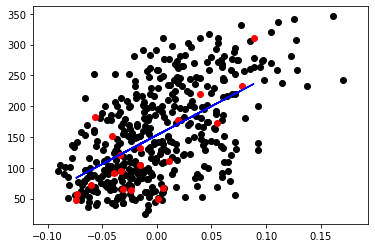

In [6]:
import matplotlib.pyplot as plt

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w[0]*diabetes_X_test)+bias, color='blue')

### Linear Regression Direct Solve

#### Least squares formulation
w* = argminw ||Xw-y||2 = argminw (y - Xw)'(y - Xw) = argminw (w'(X'X)w - w'(X'y))/2

#### Setting the gradient
dw = (X'X)w - (X'y) to 0, w = (X'X)-1(X' y) = solve(X'X, X'y)

The following cell creates and runs a script using Apache SystemML that generates a small Spark job for distributed data processing.

In [7]:
script = """
    # add constant feature to X to model intercept
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    A = t(X) %*% X
    b = t(X) %*% y
    w = solve(A, b)
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]
"""

prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.001 sec.
Number of executed Spark inst:	2.




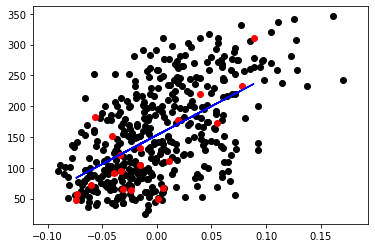

In [8]:
# Display the results with matplotlib.
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='blue')

### Linear Regression Batch Gradient Descent



Create and execute an Apache SystemML script that uses Spark to distribute data processing.

In [9]:
script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    max_iter = 100
    w = matrix(0, rows=ncol(X), cols=1)
    for(i in 1:max_iter){
        XtX = t(X) %*% X
        dw = XtX %*%w - t(X) %*% y
        alpha = -(t(dw) %*% dw) / (t(dw) %*% XtX %*% dw)
        w = w + dw*alpha
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w').output('bias')
w, bias = ml.execute(prog).get('w', 'bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.131 sec.
Number of executed Spark inst:	2.




Visualize the results with matplotlib

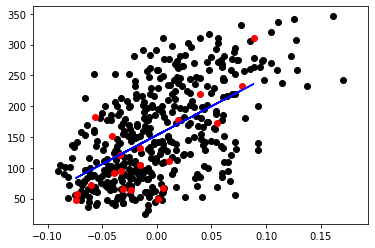

In [10]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='blue')